# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [94]:
import numpy as np
from numpy import linalg
import functions as fn
import seismic_model as sm
import optimizer as opt
from matplotlib import pyplot as plt
from obspy.taup import TauPyModel
import importlib

***
#### Synthetic Parameters
***

Original params:  [313.38472973  79.04961039  59.40920946]


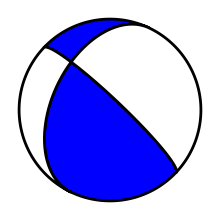

In [95]:
# seed = np.random.randint(0, 2024)
# np.random.seed(seed)
# print(f'Seed: {seed}')
# np.random.seed(2024)
np.random.seed(1513)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get truen params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
velocities = np.array([5.8000, 3.4600])

***
#### Hybrid Inversion
***

In [96]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
best_fit = inv_model(np.deg2rad(true_params), set_Ao=True)

# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 30
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.convergence_rate():.0f}%')

Run 0 of 30
Run 10 of 30
Run 20 of 30
Convergence rate: 97%


Axis: T
Optimal parameters: [83.9011179  39.99647742  4.70537768]
Search error: 0.019693325370624456 degrees


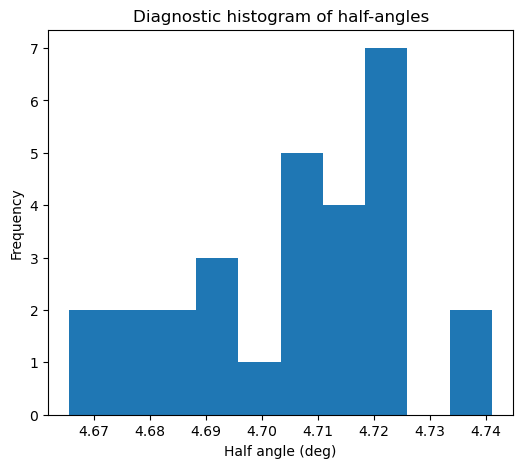

In [97]:
params, error, position = inv_model.optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

inv_model.plot_half_angles(bins=10)

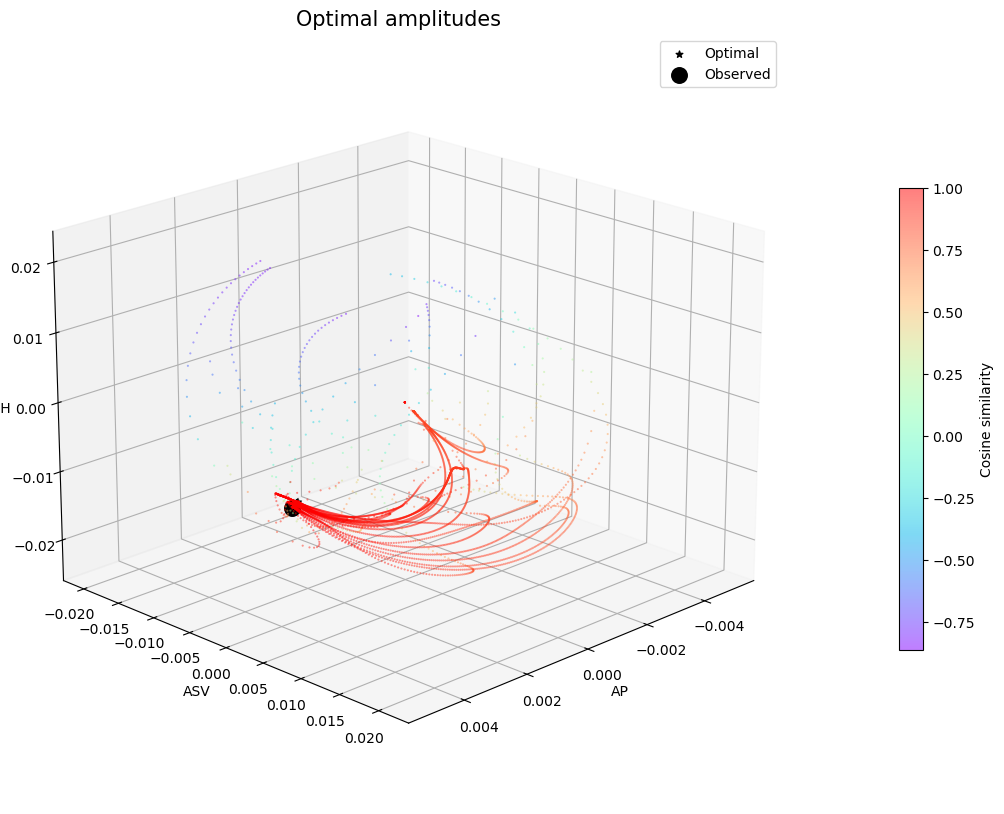

In [98]:
# amplitude plot
inv_model.plot_amplitudes(azim=45, elev=20, s=25, alpha=0.5, iterates=True)

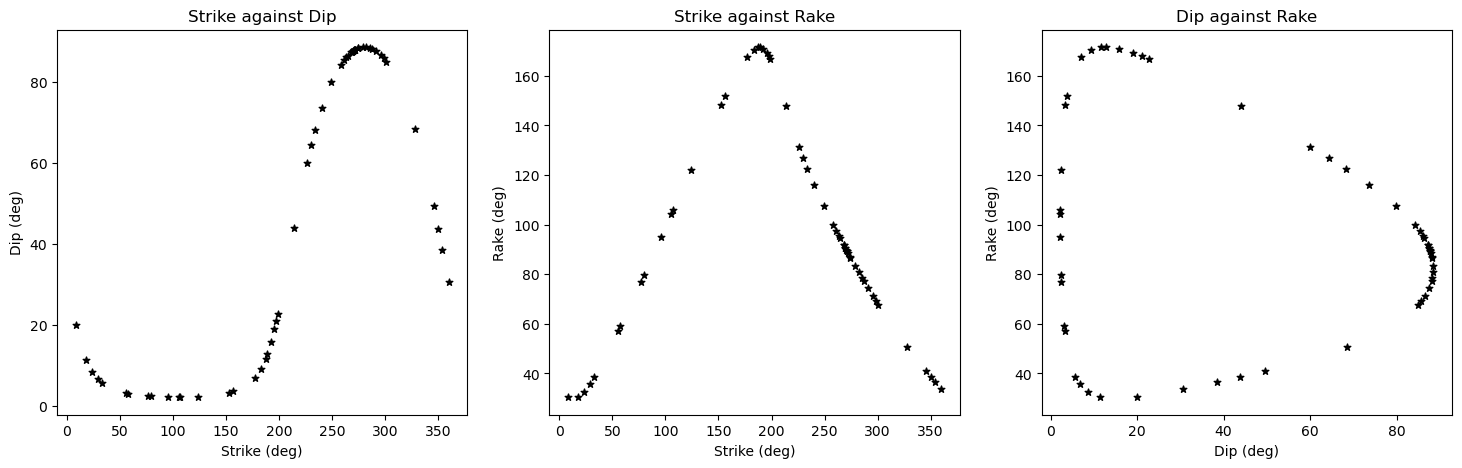

In [99]:
# iterate plot - sdr space
inv_model.plot_iterates_2D(s=25, optimal=True, index=2)
# inv_model.plot_iterates_2D(s=1, optimal=False, index=0)
# inv_model.plot_iterates_2D(s=1, optimal=False, index=1)
# inv_model.plot_iterates_3D(s=25, optimal=True, index=2)

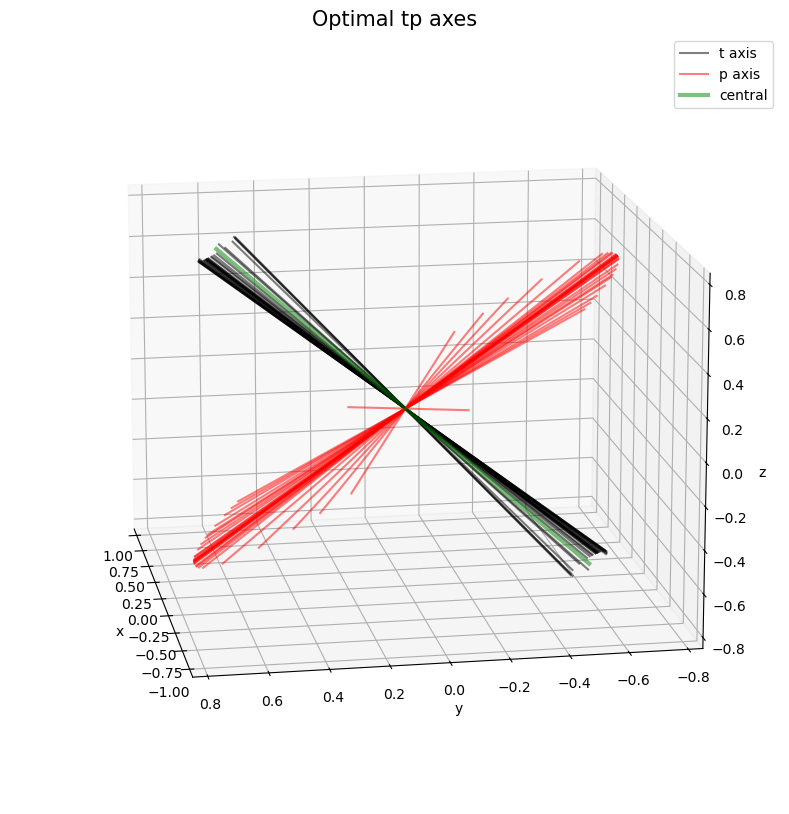

In [100]:
# optimal plot - tp space
inv_model.plot_tp_axes(azim=170, elev=15, half=False)

***
#### Uncertainty Propagation
***

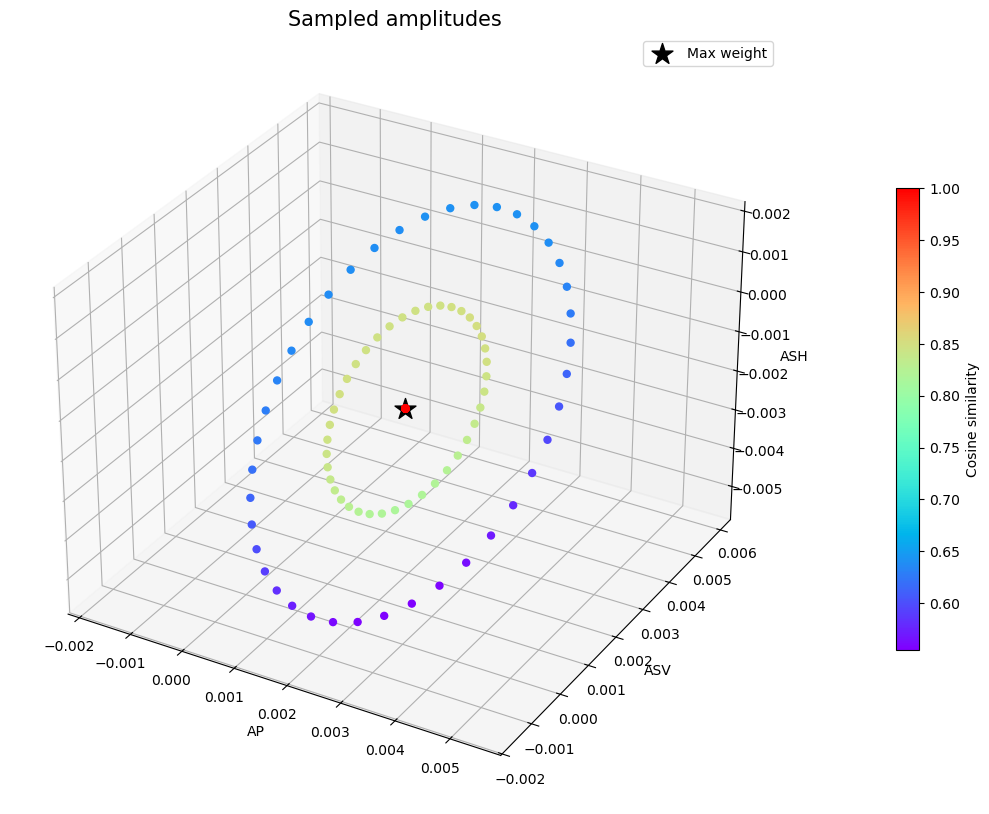

In [109]:
dd, num_samples = 9, 90
# dd, num_samples = 30, 15  # debugging
inv_model.init_uncertainty()
inv_model.sample_amplitudes(dd, num_samples)
inv_model.plot_sampled_amplitudes(cmap='rainbow', s=25)

In [110]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 100
Sample 1 of 100
Sample 2 of 100
Sample 3 of 100
Sample 4 of 100
Sample 5 of 100
Sample 6 of 100
Sample 7 of 100
Sample 8 of 100
Sample 9 of 100
Sample 10 of 100
Sample 11 of 100
Sample 12 of 100
Sample 13 of 100
Sample 14 of 100
Sample 15 of 100
Sample 16 of 100
Sample 17 of 100
Sample 18 of 100
Sample 19 of 100
Sample 20 of 100
Sample 21 of 100
Sample 22 of 100
Sample 23 of 100
Sample 24 of 100
Sample 25 of 100
Sample 26 of 100
Sample 27 of 100
Sample 28 of 100
Sample 29 of 100
Sample 30 of 100
Sample 31 of 100
Sample 32 of 100
Sample 33 of 100
Sample 34 of 100
Sample 35 of 100
Sample 36 of 100
Sample 37 of 100
Sample 38 of 100
Sample 39 of 100
Sample 40 of 100
Sample 41 of 100
Sample 42 of 100
Sample 43 of 100
Sample 44 of 100
Sample 45 of 100
Sample 46 of 100
Sample 47 of 100
Sample 48 of 100
Sample 49 of 100
Sample 50 of 100
Sample 51 of 100
Sample 52 of 100
Sample 53 of 100
Sample 54 of 100
Sample 55 of 100
Sample 56 of 100
Sample 57 of 100
Sample 58 of 100
Sample 

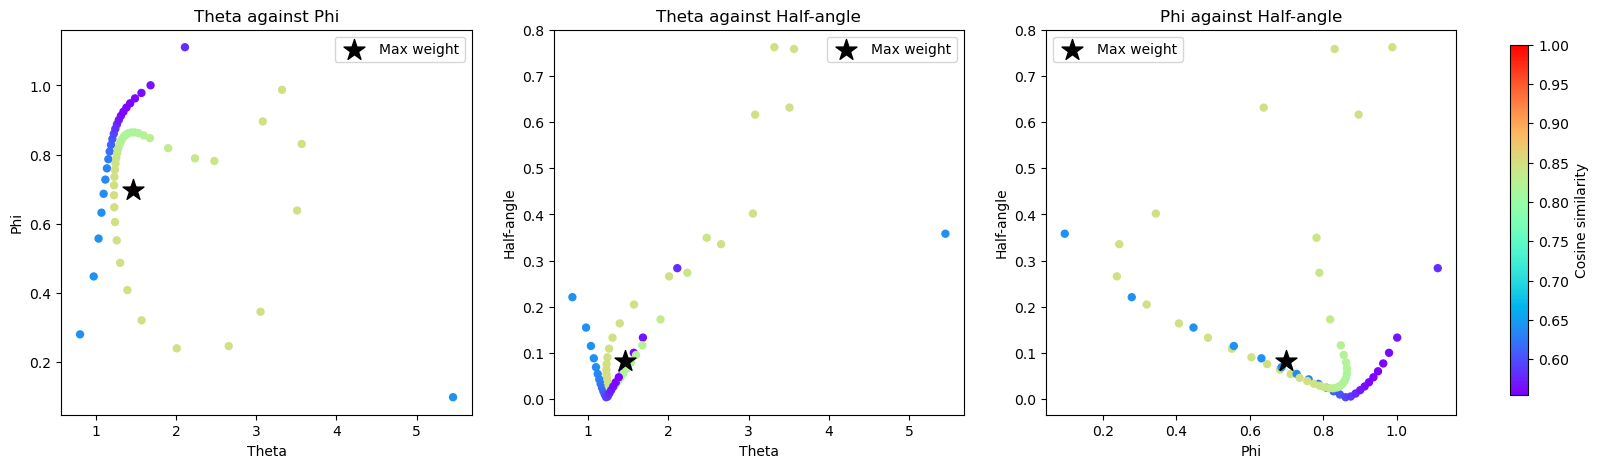

In [125]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
inv_model.plot_uncertainty_2D(s=25)
# inv_model.plot_uncertainty_3D(elev=30, azim=45, s=25)

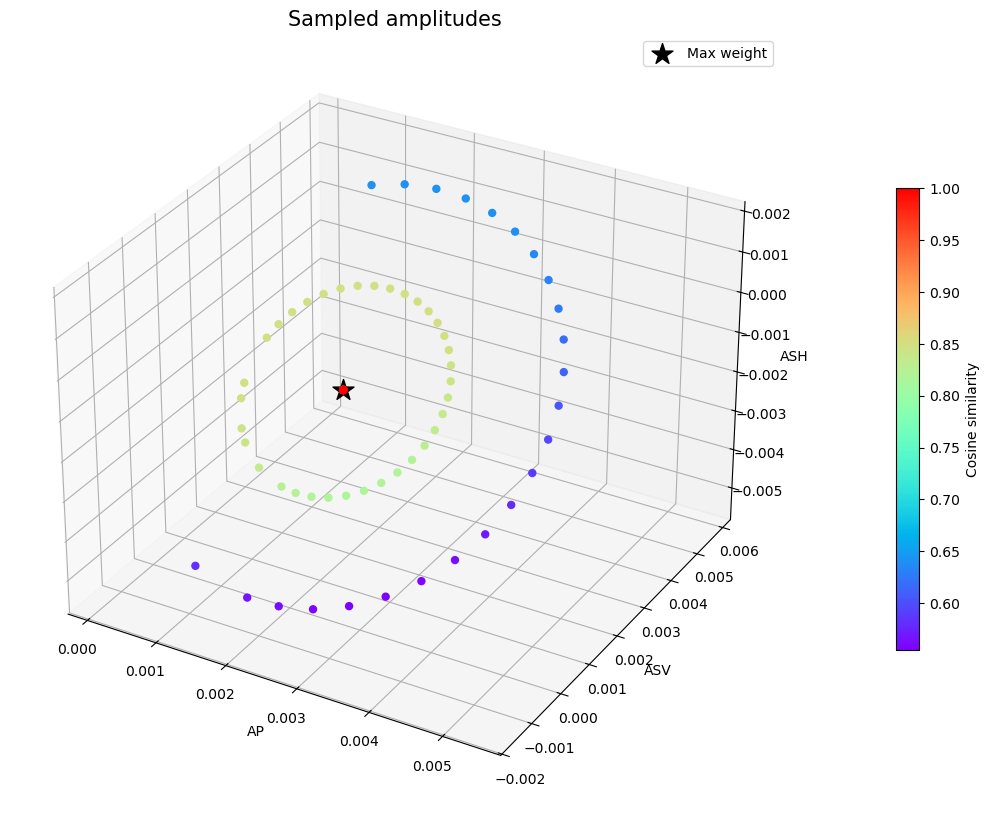

In [126]:
inv_model.plot_sampled_amplitudes(cmap='rainbow', s=25)

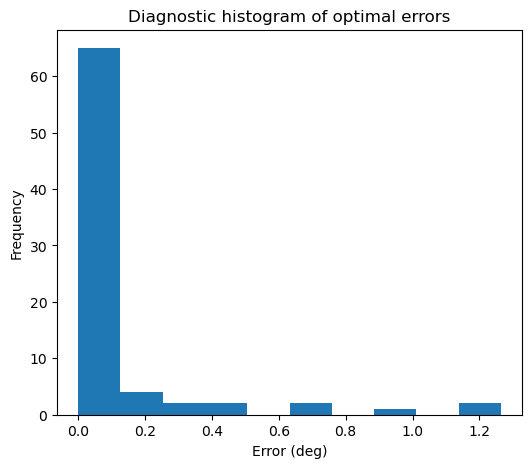

In [118]:
# diagnostic plot of monte carlo errors
inv_model.plot_optimal_errors(bins=10)

#### Insights

* Some of this is numerical stability of underlying algorithms!
* But the method points to an identifiable shape in 3D which happens to lie in a plane that can also be identified.
* We can use PCA to  get exactly what we're looking for, because it looks like a hyperbola. Another quadric surface :)
* That would also explain the numerical instability so well!
* The narrower the original cone, the better. There's probably a perfect mechanism for this method: one whose half-angle is 0. And you can recogmize it by the shapes it forms in SDR space: sin, cos and circle! Finding it might make it easier to quantify numerical stability.
* The thing we can do is fit a plane and locate the direction of rotation that decreases half angle (~numerical stability) the most, then put this on the plot of tp axes.
* With more time, we can also characterize beachballs.